Kütüphanelerin Import Edilmesi

In [ ]:
#Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

Veri Önişleme

In [ ]:
#Veri setinin yüklenmesi ve temizlenmesi
df = pd.read_csv("AirQualityUCI.csv", sep=";", decimal=",", encoding="latin1", low_memory=False)

df.dropna(axis=1, how="all", inplace=True)
df.replace(-200, np.nan, inplace=True)

if "NMHC(GT)" in df.columns:
    df.drop(columns=["NMHC(GT)"], inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df_cleaned = df.dropna(subset=['Date', 'Time'])

#En çok tekrar eden değer ile 2. en çok tekrar eden değer arasında büyük fark varsa o değeri çıkar
suspicious_values = {}

for column in df_cleaned.select_dtypes(include=[np.number]).columns:
    counts = df_cleaned[column].value_counts()
    if len(counts) >= 2:
        top1 = counts.iloc[0]
        top2 = counts.iloc[1]
        if top1 > 3 * top2:  # 3 kat fark varsa şüpheli
            suspicious_values[column] = counts.index[0]

#Bu şüpheli değerleri veriden çıkar
for col, val in suspicious_values.items():
    df_cleaned = df_cleaned[df_cleaned[col] != val]

In [ ]:
#HKİ(Hava kalitesi indeksi) sınıflandırması (yüzdelik dilimlere göre)
def label_air_quality_by_quantile(pm10, so2, no2, q_pm10, q_so2, q_no2):
    def get_score(val, q):
        return 1 if val <= q[0.33] else 2 if val <= q[0.66] else 3
    return max(
        get_score(pm10, q_pm10),
        get_score(so2, q_so2),
        get_score(no2, q_no2)
    )

df_model = df_cleaned.copy()
col_pm10 = "PT08.S4(NO2)"
col_co = "PT08.S1(CO)"
col_no2 = "NO2(GT)"

q_pm10 = df_model[col_pm10].quantile([0.33, 0.66])
q_co = df_model[col_co].quantile([0.33, 0.66])
q_no2 = df_model[col_no2].quantile([0.33, 0.66])

df_model["HKI"] = df_model.apply(lambda row: label_air_quality_by_quantile(
    row[col_pm10], row[col_co], row[col_no2], q_pm10, q_co, q_no2
), axis=1)

In [ ]:
# Model eğitimi için kullanılmayacak sütunları (tarih, zaman, hedef değişken ve doğrudan etki eden sütunlar) dışarıda bırakıyoruz
features_to_exclude = ["Date", "Time", "HKI", col_pm10, col_co, col_no2]
# Geriye kalan sütunları özellik (feature) olarak alıyoruz
X = df_model.drop(columns=features_to_exclude)
# Hedef değişken olarak HKI (Hava Kalitesi İndeksi) sütunu kullanılıyor
y = df_model["HKI"]

Veri Bölme ve Ölçekleme İşlemleri

In [ ]:
#Veriyi test ve eğitim olarak ayırma ve min-max ölçekleme
#Verinin %30'u test, kalan %70'i eğitim için kullanılır.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Sonuçları saklamak için sözlük
model_sonuclari = {}

Lojistik Regresyon

In [ ]:
#Gerekli sınıfı import etme
from sklearn.linear_model import LogisticRegression
#Lojistik Regresyon modelini oluşturma (max iter sayısı 1000)
lr = LogisticRegression(max_iter=1000)

#Modeli eğitim verisiyle eğitme
lr.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_lr = lr.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["Lojistik Regresyon"] = accuracy_score(y_test, y_pred_lr)

k-En Yakın Komşu (KNN)

In [ ]:
#Gerekli sınıfı import etme
from sklearn.neighbors import KNeighborsClassifier

#k-En Yakın Komşu (KNN) modelini oluşturma (komşu sayısı = 5)
knn = KNeighborsClassifier(n_neighbors=5)

#Modeli epitim verisiyle eğitme
knn.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_knn = knn.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama
acc_knn = accuracy_score(y_test, y_pred_knn)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["kNN"] = acc_knn


Rastgele Orman (Random Forest)

In [ ]:
#Gerekli sınıfı import etme
from sklearn.ensemble import RandomForestClassifier
#Rastgele Orman (Random Forest) modelini oluşturma (rastgelelik kontrolü için random_state=42)

rf = RandomForestClassifier(random_state=42)

#Modeli eğitim verisiyle eğitme
rf.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_rf = rf.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama
acc_rf = accuracy_score(y_test, y_pred_rf)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["Random Forest"] = acc_rf


Karar Ağacı (Decision Tree)

In [ ]:
#Gerekli sınıfı import etme
from sklearn.tree import DecisionTreeClassifier

#Karar Ağacı (Decision Tree) modelini oluşturma (rastgelelik kontrolü için random_state=42)
dt = DecisionTreeClassifier(random_state=42)

#Modeli eğitim verisiyle eğitme
dt.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_dt = dt.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama
acc_dt = accuracy_score(y_test, y_pred_dt)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["Decision Tree"] = acc_dt


Naive Bayes

In [ ]:
#Gerekli sınıfı import etme
from sklearn.naive_bayes import GaussianNB

#Naive Bayes modelini oluşturma
nb = GaussianNB()

#Modeli eğitim verisiyle eğitme
nb.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_nb = nb.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama
acc_nb = accuracy_score(y_test, y_pred_nb)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["Naive Bayes"] = acc_nb


Yapay Sinir Ağı (MLPClassifier)

In [ ]:
#Gerekli sınıfı import etme
from sklearn.neural_network import MLPClassifier

#Yapay Sinir Ağı (MLPClassifier) modelini oluşturma
#1 gizli katman ve 100 nöron ile, maksimum 1000 iterasyon ve sabit rastgelelik ile
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

#Modeli eğitim verisiyle eğitme
mlp.fit(X_train_scaled, y_train)

#Test verisiyle tahmin yapma
y_pred_mlp = mlp.predict(X_test_scaled)

#Modelin doğruluğunu hesaplama
acc_mlp = accuracy_score(y_test, y_pred_mlp)

#Modelin doğruluğunu hesaplama ve sonuçlar sözlüğüne ekleme
model_sonuclari["Yapay Sinir Ağı"] = acc_mlp


In [ ]:
#Sözlük formatındaki model doğruluk skorlarını DataFrame'e dönüştürme
#Her satır bir model ve onun doğruluk skorunu temsil eder
results_df = pd.DataFrame(list(model_sonuclari.items()), columns=["Model", "Doğruluk"])

#DataFrame'i doğruluk değerlerini azalan şekilde sıralaama
results_df.sort_values(by="Doğruluk", ascending=False, inplace=True)

#Sonuç tablosunu gösterme
results_df

,Model,Doğruluk
2,Random Forest,0.890808
5,Yapay Sinir Ağı,0.872524
1,kNN,0.871508
3,Decision Tree,0.861351
0,Lojistik Regresyon,0.807517
4,Naive Bayes,0.761808


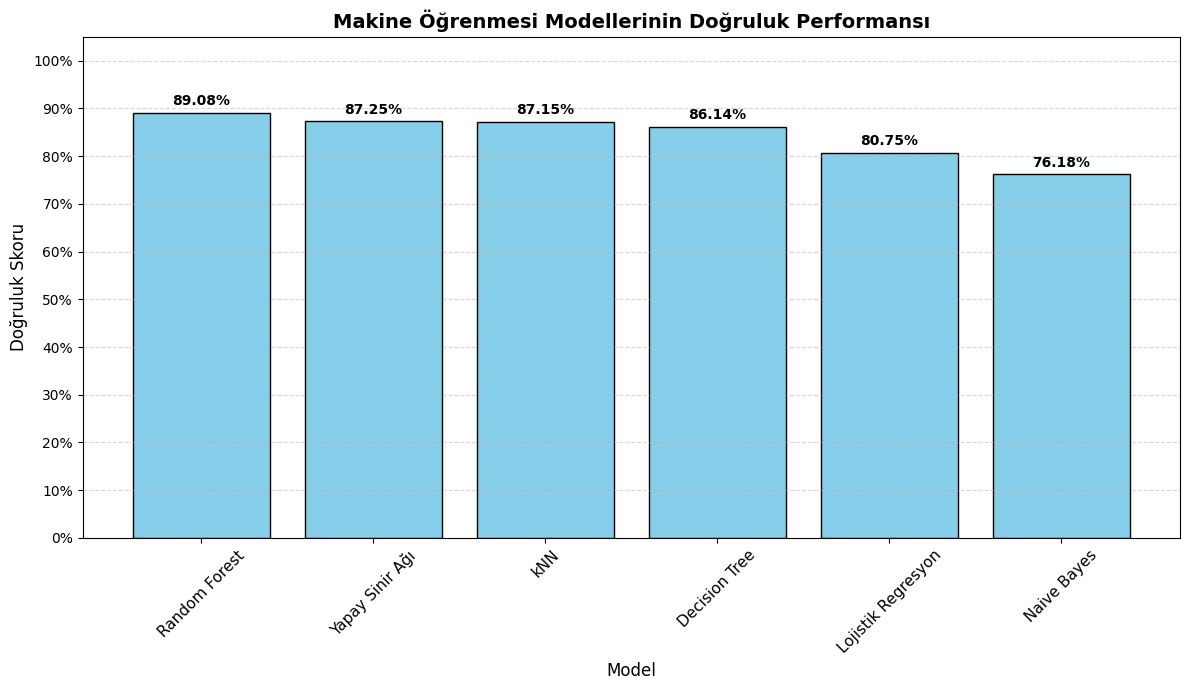

In [ ]:
import matplotlib.pyplot as plt

# Sonuçları görselleştirme
# Geliştirilmiş ve görsel açıdan zenginleştirilmiş grafik
plt.figure(figsize=(12, 7))
bars = plt.bar(results_df["Model"], results_df["Doğruluk"], color='skyblue', edgecolor='black')

# Doğruluk değerlerini çubukların üstüne yaz
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f"{height:.2%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Grafik detayları
plt.ylabel("Doğruluk Skoru", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.title("Makine Öğrenmesi Modellerinin Doğruluk Performansı", fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.1), [f"{int(tick*100)}%" for tick in np.arange(0, 1.1, 0.1)])

plt.tight_layout()
plt.show()

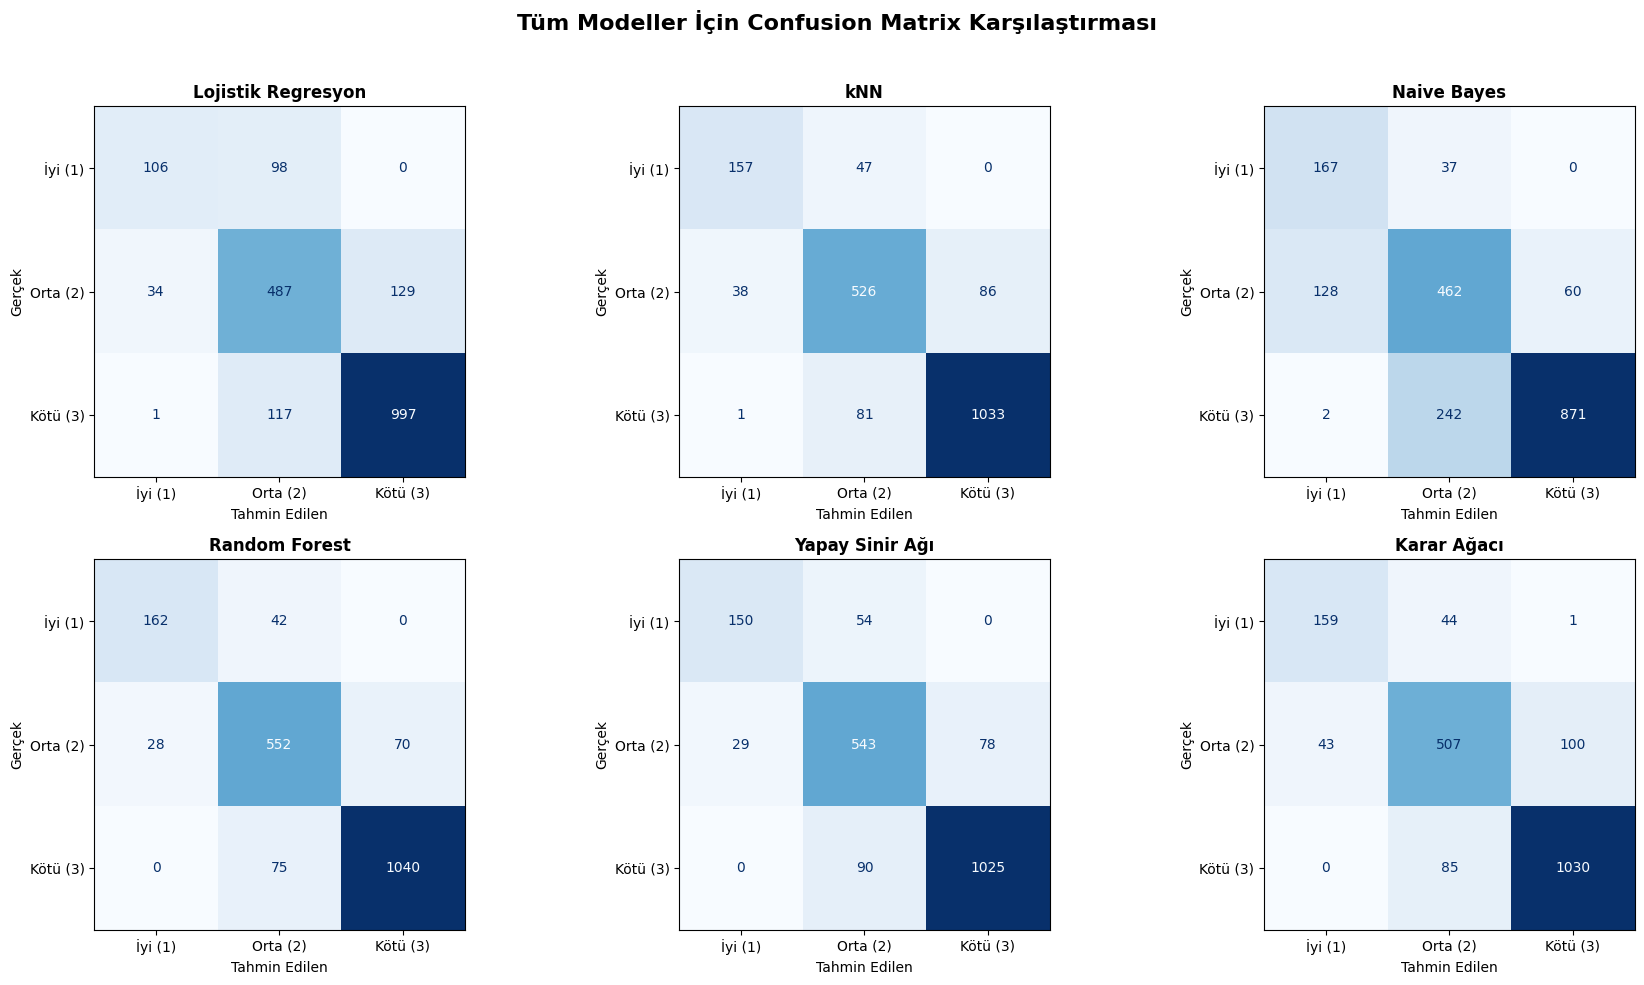

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Tüm modellerin confusion matrix'lerini aynı anda görselleştirelim
model_preds = {
    "Lojistik Regresyon": y_pred_lr,
    "kNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf,
    "Yapay Sinir Ağı": y_pred_mlp,
    "Karar Ağacı": y_pred_dt
}

# Grafik alanı ayarla
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Her model için confusion matrix çiz
for idx, (model_adi, y_pred) in enumerate(model_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["İyi (1)", "Orta (2)", "Kötü (3)"])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d', colorbar=False)
    axes[idx].set_title(model_adi, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Tahmin Edilen", fontsize=10)
    axes[idx].set_ylabel("Gerçek", fontsize=10)

plt.suptitle("Tüm Modeller İçin Confusion Matrix Karşılaştırması", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


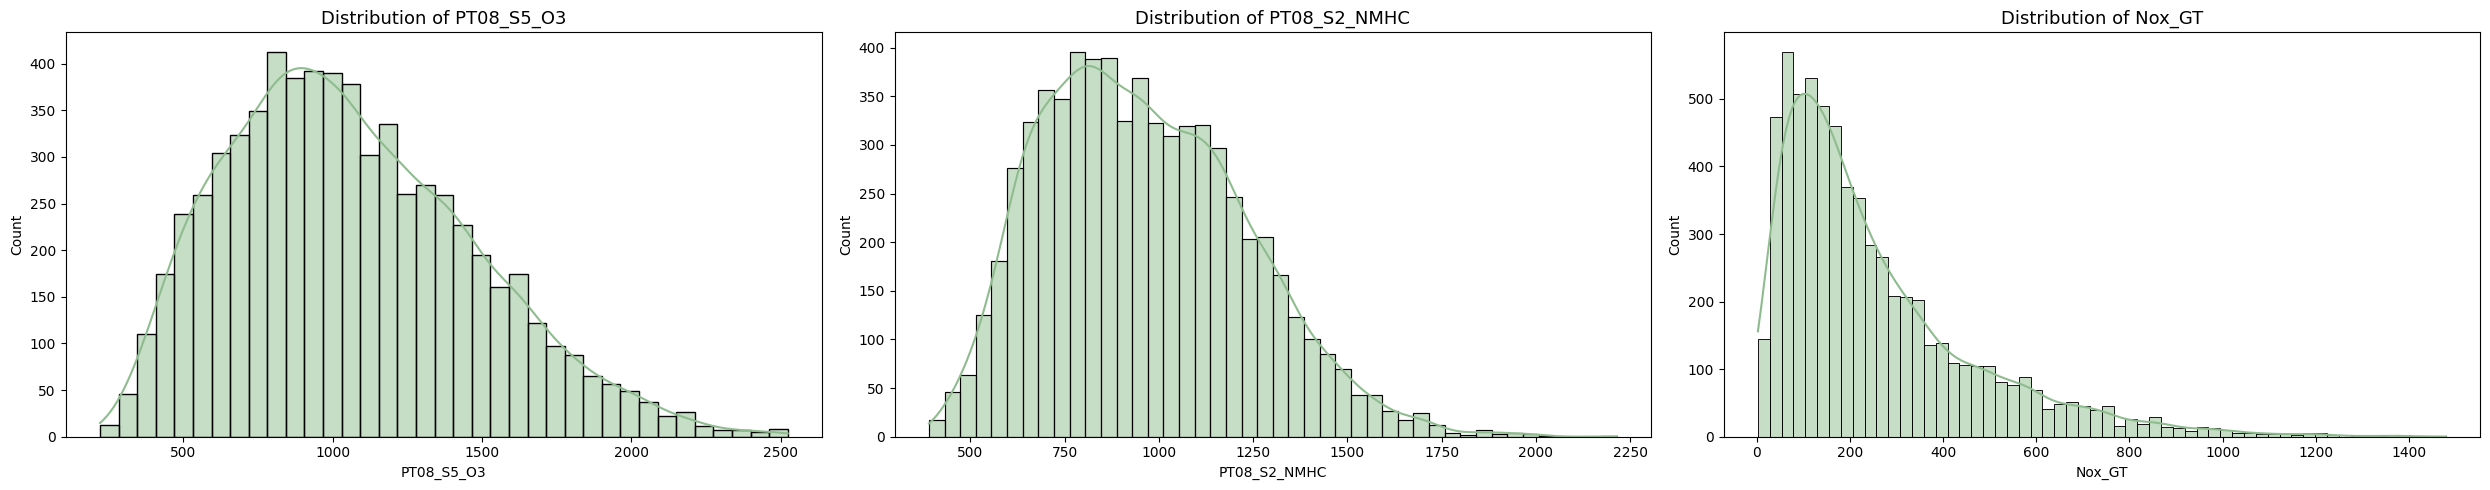

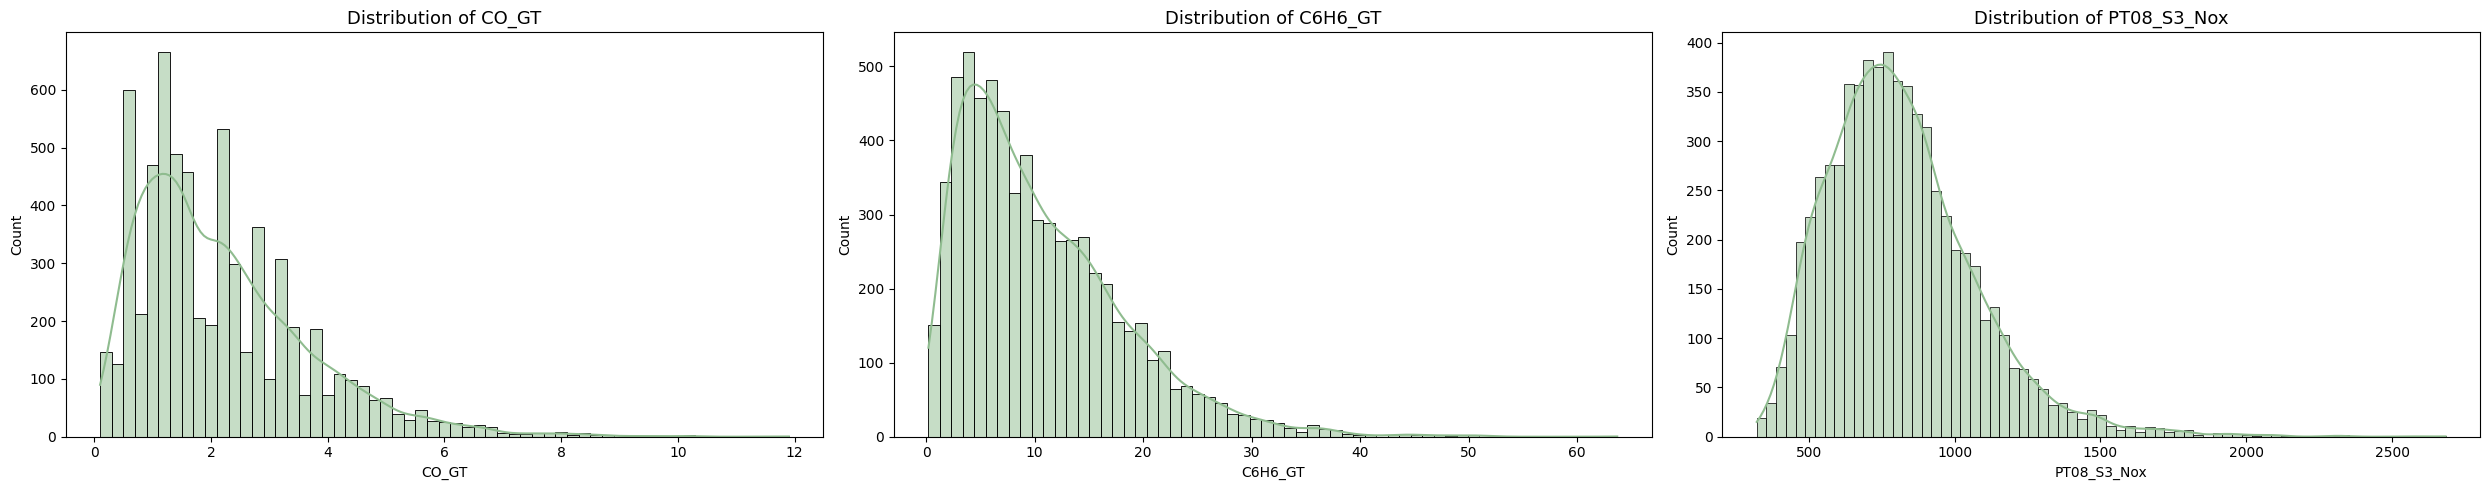

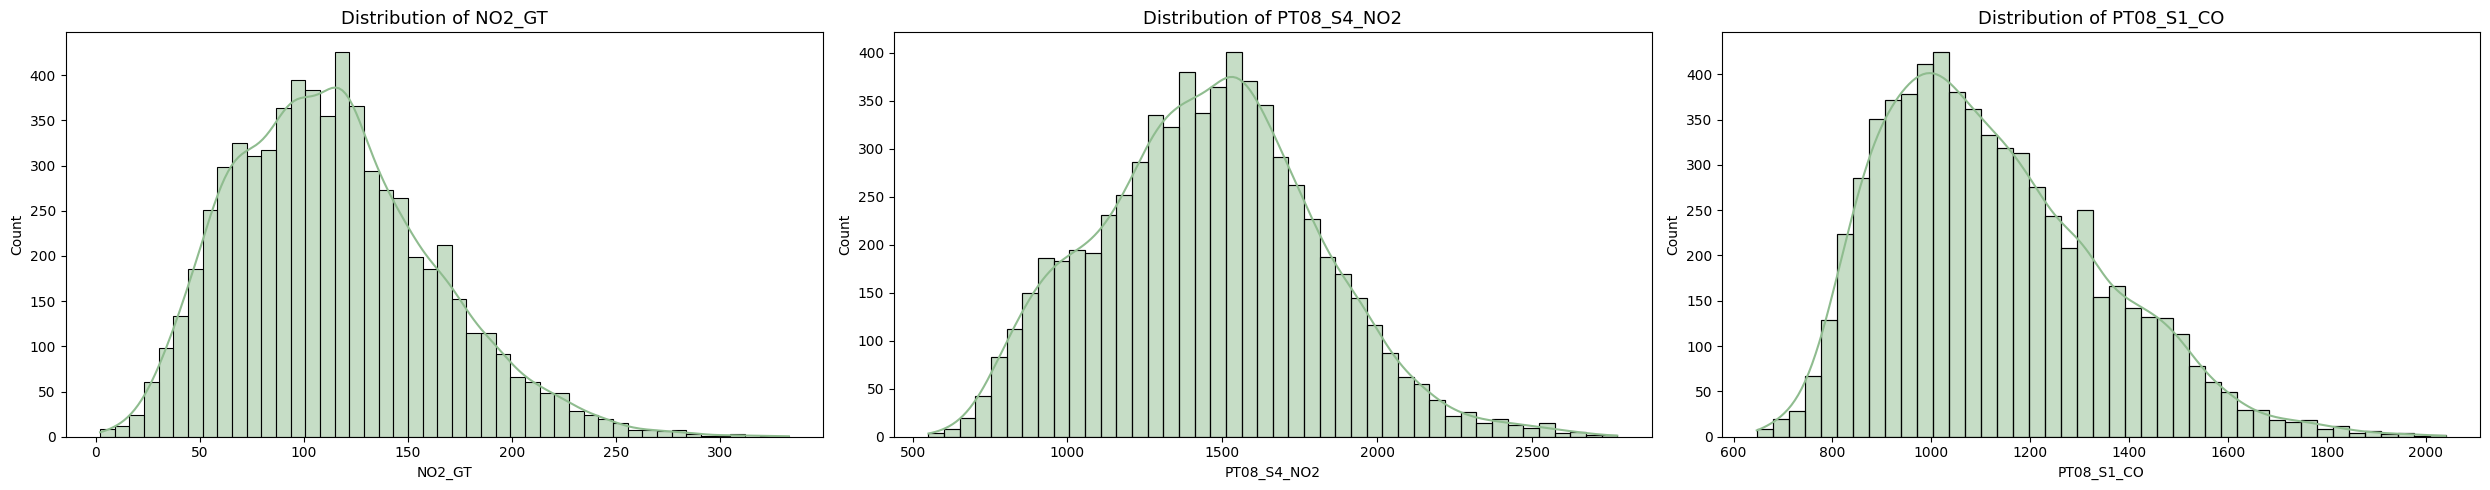

In [ ]:
import seaborn as sns

# Sütun isimlerini veri setine uygun hâle getirelim
df_viz = df_cleaned.rename(columns={
    "PT08.S1(CO)": "PT08_S1_CO",
    "PT08.S2(NMHC)": "PT08_S2_NMHC",
    "NOx(GT)": "Nox_GT",
    "CO(GT)": "CO_GT",
    "C6H6(GT)": "C6H6_GT",
    "PT08.S3(NOx)": "PT08_S3_Nox",
    "NO2(GT)": "NO2_GT",
    "PT08.S4(NO2)": "PT08_S4_NO2",
    "PT08.S5(O3)": "PT08_S5_O3"
})

# Dağılım gösterme fonksiyonu
def showDistributions(category1, category2, category3):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))
    sns.histplot(data=df_viz, x=category1, kde=True, color="darkseagreen", ax=axes[0])
    axes[0].set_title(f"Distribution of {category1}", fontsize=13)

    sns.histplot(data=df_viz, x=category2, kde=True, color="darkseagreen", ax=axes[1])
    axes[1].set_title(f"Distribution of {category2}", fontsize=13)

    sns.histplot(data=df_viz, x=category3, kde=True, color="darkseagreen", ax=axes[2])
    axes[2].set_title(f"Distribution of {category3}", fontsize=13)

    plt.tight_layout()
    plt.show()

# 3 set dağılım görselleştirmesi
showDistributions("PT08_S5_O3", "PT08_S2_NMHC", "Nox_GT")
showDistributions("CO_GT", "C6H6_GT", "PT08_S3_Nox")
showDistributions("NO2_GT", "PT08_S4_NO2", "PT08_S1_CO")
